## Load required packages

In [43]:
import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
from cyclone.util.tools import set_seed
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
import numpy as np
import matplotlib.pyplot as plt
from cyclone.train import cyclone
from cyclone.util.preprocess import data_preprocess

scanpy==1.9.5 anndata==0.9.1 umap==0.5.3 numpy==1.25.2 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.14.0 igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.10


## Set seed

In [44]:
set_seed(2023)

## Read data and data pre-processing

In [6]:
# This data could be downloaded from https://drive.google.com/drive/folders/1WpWU1YCdCOhXAqGceOG5RzoskUfc-WSE

adata = sc.read_h5ad('simulation.h5ad')

adata = data_preprocess(adata, batch_key='Batch', label_key='Group', select_hvg=2000, scale=True)

## Run cyclone

In default mode, function `cyclone` would return an AnnData object with embedding and clustering result stored in `adata.obsm['cyclone_emb']` and `adata.obs['cyclone_cluster']`

function `cyclone` would return and print all temporate results:

- adata: An AnnData object with embedding.
- nmi: Clustering result NMI.
- ari: Clustering result ARI.
- k: The number of clusters by Leiden, If k is not equal to the true number of cell types, we can adjust the resolution to the true number of cells within the function `cyclone` 
- run_time: The time it takes for the model training.
- BASW: BASW value.
- BER: BER value.
- mnn_index: A list with the results of each update.

In [45]:
adata, nmi, ari, k, run_time, BASW, BER, mnn_index = cyclone(adata,
                                                                      batch_size=256,
                                                                      vae_z_dim=32,
                                                                      h_dim=16,
                                                                      encode_layers=[1024, 512, 256],
                                                                      decode_layers=[256, 512, 1024],
                                                                      lr_vae=0.0002,
                                                                      train_epoch=30)

cuda:0
Defined ops:  ['int']
computeing anchors
Number of training samples = 3445
train epoch [1/30]. MSE loss:1.0821, KLD loss:5.3371, Contrast loss:0.0059, total loss:1.0854
train epoch [2/30]. MSE loss:1.0139, KLD loss:8.9305, Contrast loss:0.0019, total loss:1.0185
train epoch [3/30]. MSE loss:1.0051, KLD loss:11.7988, Contrast loss:0.0015, total loss:1.0111
train epoch [4/30]. MSE loss:1.0030, KLD loss:10.7776, Contrast loss:0.0015, total loss:1.0086
train epoch [5/30]. MSE loss:1.0029, KLD loss:8.6705, Contrast loss:0.0015, total loss:1.0074
train epoch [6/30]. MSE loss:1.0029, KLD loss:7.1751, Contrast loss:0.0015, total loss:1.0067
train epoch [7/30]. MSE loss:1.0037, KLD loss:6.2560, Contrast loss:0.0014, total loss:1.0069
train epoch [8/30]. MSE loss:1.0025, KLD loss:5.7497, Contrast loss:0.0014, total loss:1.0055
train epoch [9/30]. MSE loss:1.0021, KLD loss:5.3430, Contrast loss:0.0014, total loss:1.0049
train epoch [10/30]. MSE loss:0.9999, KLD loss:4.7679, Contrast loss:0

In [46]:
print(f'ARI: {ari}')
print(f'NMI: {nmi}')
print(f'K: {k}')
print(f'BASW: {BASW}')
print(f'BER: {BER}')
print(f'run_time: {run_time}')

ARI: 1.0
NMI: 1.0
K: 4
BASW: 0.9787141550332308
BER: 0.0
run_time: 47.91168737411499


## Visualization

### Show final clustering and batch effect removing results

In [47]:
# Use embedding `cyclone_emb` to perfrom U-map
sc.pp.neighbors(adata, use_rep='cyclone_emb')
sc.tl.umap(adata)

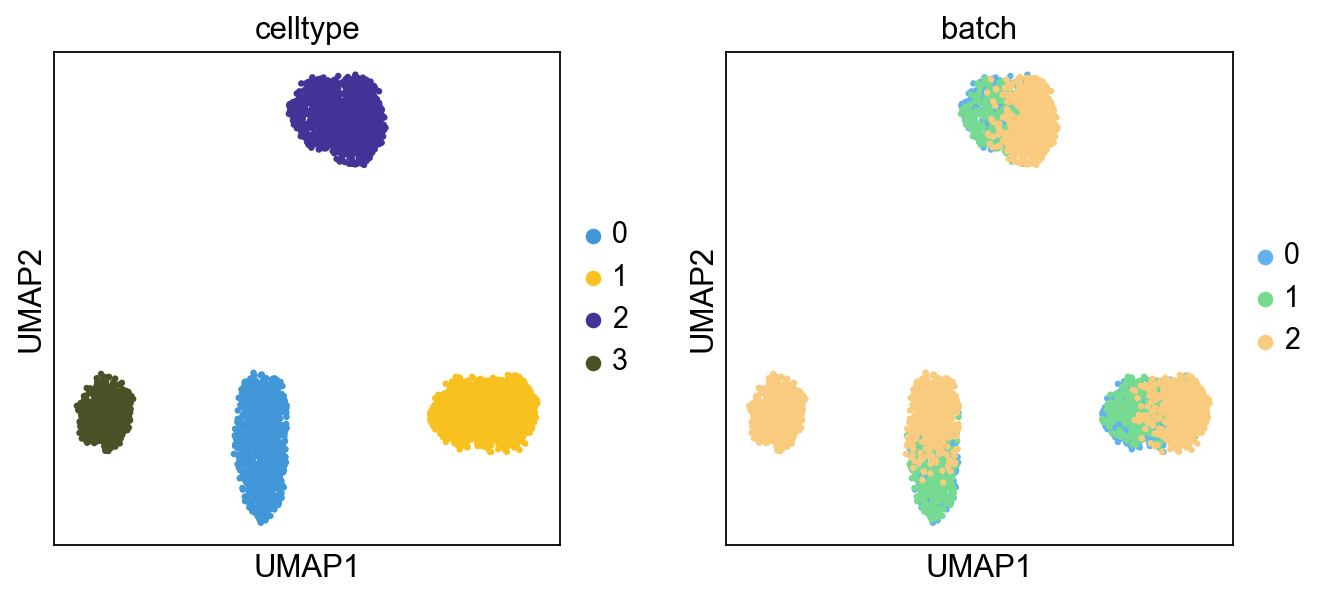

In [48]:
%matplotlib inline
adata.obs['celltype'] = adata.obs['celltype'].astype(int).astype('category')
adata.obs['batch'] = adata.obs['Batch'].astype(int).astype('category')
sc.pl.umap(adata, color=['celltype', 'batch'])

### Show Heatmap of positive sample pair matching accuracy

In [49]:
# mnn_index[0] is the index of the first epoch of MNN pairs
# mnn_index[1] is the index of the 10th epoch of MNN pairs
# mnn_index[2] is the index of the 20th epoch of MNN pairs
a_index = mnn_index[0]
b_index = mnn_index[1]
c_index = mnn_index[2]

[[0.33013845 0.32055378 0.2715655  0.07774228]
 [0.26934097 0.38395415 0.27698185 0.06972302]
 [0.24749499 0.29759519 0.37074148 0.08416834]
 [0.34883721 0.31395349 0.30813953 0.02906977]]


Text(0.5, 1.0, 'epoch = 1')

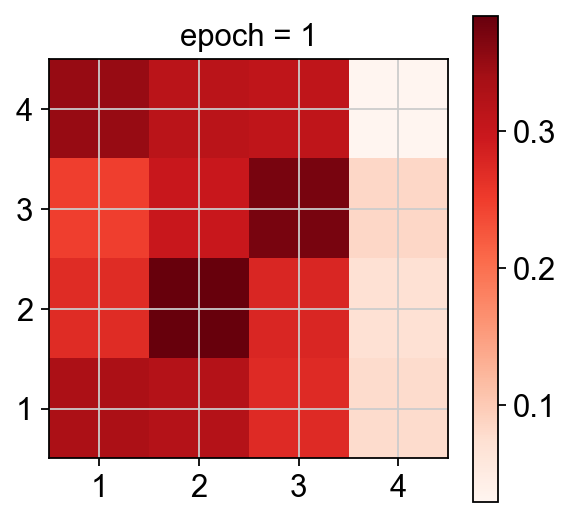

In [50]:
#The first epoch of Heatmap
n_cell = len(np.unique(adata.obs['celltype']))
positive_matrixa = np.zeros((n_cell, n_cell), dtype=int)
for celltype in range(n_cell):
    celltype_indices = np.where(adata.obs['celltype'] == celltype)[0]
    celltype_pos_indices = a_index[celltype_indices]
    celltype_pos_celltypes = adata.obs['celltype'][celltype_pos_indices]
    celltype_pos_counts = np.bincount(celltype_pos_celltypes, minlength=n_cell)
    positive_matrixa[celltype, :] = celltype_pos_counts

row_sums = positive_matrixa.sum(axis=1)
positive_matrix_normalized_a = positive_matrixa / row_sums[:, np.newaxis]

print(positive_matrix_normalized_a)
plt.imshow(positive_matrix_normalized_a, cmap='Reds',origin='lower', extent=[0.5, n_cell+0.5, 0.5, n_cell+0.5])
plt.yticks(np.arange(1, n_cell+1), np.arange(1, n_cell+1))
plt.xticks(np.arange(1, n_cell+1), np.arange(1, n_cell+1))
plt.colorbar()
plt.title("epoch = 1")

[[0.67305644 0.14057508 0.10117146 0.08519702]
 [0.12893983 0.60649475 0.17765043 0.086915  ]
 [0.08016032 0.19438878 0.68136273 0.04408818]
 [0.37790698 0.38953488 0.20542636 0.02713178]]


Text(0.5, 1.0, 'epoch = 10')

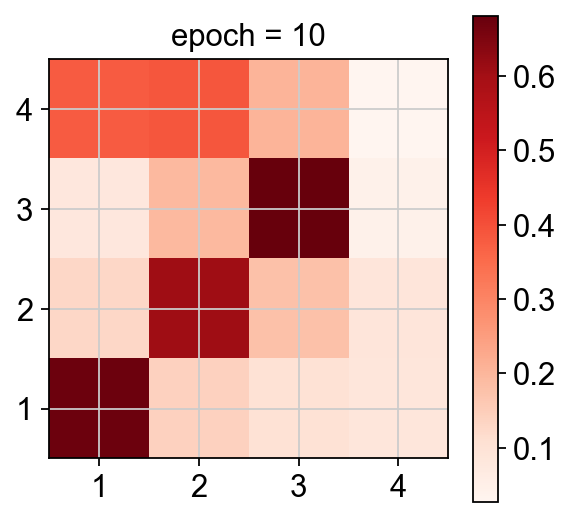

In [51]:
#The 10th epoch of Heatmap
positive_matrixb = np.zeros((n_cell, n_cell), dtype=int)
for celltype in range(n_cell):
    celltype_indices = np.where(adata.obs['celltype'] == celltype)[0]
    celltype_pos_indices = b_index[celltype_indices]
    celltype_pos_celltypes = adata.obs['celltype'][celltype_pos_indices]
    celltype_pos_counts = np.bincount(celltype_pos_celltypes, minlength=n_cell)
    positive_matrixb[celltype, :] = celltype_pos_counts

row_sums = positive_matrixb.sum(axis=1)
positive_matrix_normalized_b = positive_matrixb / row_sums[:, np.newaxis]

print(positive_matrix_normalized_b)
plt.imshow(positive_matrix_normalized_b, cmap='Reds', origin='lower', extent=[0.5, n_cell+0.5, 0.5, n_cell+0.5])
plt.yticks(np.arange(1, n_cell+1), np.arange(1, n_cell+1))
plt.xticks(np.arange(1, n_cell+1), np.arange(1, n_cell+1))
plt.colorbar()
plt.title("epoch = 10")

[[0.91160809 0.0085197  0.00958466 0.07028754]
 [0.00859599 0.91690544 0.00477555 0.06972302]
 [0.00901804 0.00501002 0.95190381 0.03406814]
 [0.29457364 0.43992248 0.17248062 0.09302326]]


Text(0.5, 1.0, 'epoch = 20')

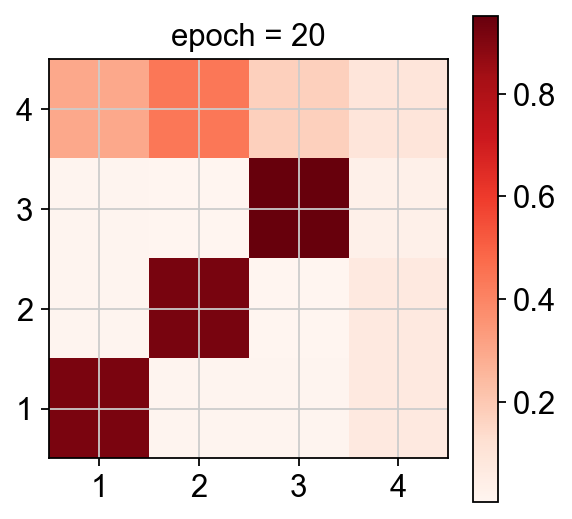

In [52]:
#The 20th epoch of Heatmap
positive_matrixc = np.zeros((n_cell, n_cell), dtype=int)
for celltype in range(n_cell):
    celltype_indices = np.where(adata.obs['celltype'] == celltype)[0]
    celltype_pos_indices = c_index[celltype_indices]
    celltype_pos_celltypes = adata.obs['celltype'][celltype_pos_indices]
    celltype_pos_counts = np.bincount(celltype_pos_celltypes, minlength=n_cell)
    positive_matrixc[celltype, :] = celltype_pos_counts

row_sums = positive_matrixc.sum(axis=1)
positive_matrix_normalized_c = positive_matrixc / row_sums[:, np.newaxis]

print(positive_matrix_normalized_c)
plt.imshow(positive_matrix_normalized_c, cmap='Reds', origin='lower', extent=[0.5, n_cell+0.5, 0.5, n_cell+0.5])
plt.yticks(np.arange(1, n_cell+1), np.arange(1, n_cell+1))
plt.xticks(np.arange(1, n_cell+1), np.arange(1, n_cell+1))
plt.colorbar()
plt.title("epoch = 20")